In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
from keras.utils.vis_utils import plot_model
np.random.seed(20)   
tf.random.set_seed(20)

In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1] 
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(),'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         freqQAmpI_filt       C_filt
0         31453.223522  5490.232850
1         31438.277060  5490.239343
2         31421.341616  5490.240838
3         31409.798761  5490.232728
4         31398.815589  5490.222463
...                ...          ...
132394    31055.686766  5457.051859
132395    31041.955345  5457.082380
132396    31035.059531  5457.111463
132397    31020.001291  5457.126443
132398    31012.016780  5457.151945

[132399 rows x 2 columns]
Target Data:
               SS    V_filt
0       5.656166  1.201004
1       5.657157  1.243144
2       5.658317  1.264215
3       5.659499  1.243144
4       5.660404  1.222074
...          ...       ...
132394  5.471059  1.285285
132395  5.474545  0.948161
132396  5.478286  1.158863
132397  5.481751  1.201004
132398  5.484813  0.526756

[132399 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape 
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132099, 300, 2)
Target shape (SS), Y =  (132099,)
Target shape (V), Y =  (132099,)
After reshaping, X =  (132099, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Train
X_train = X_train[52839:92469] 
Y_train_SS = Y_train_SS[52839:92469]
Y_train_V = Y_train_V[52839:92469]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 39630
Validation samples: 13210
Testing samples: 26420


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [ ]:
# Define DD
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                              

Train on 39630 samples, validate on 13210 samples
Epoch 1/100
39424/39630 [============================>.] - ETA: 0s - loss: 0.0391 - dense_5_loss: 0.0289 - dense_6_loss: 0.0102 - dense_5_mse: 0.0289 - dense_6_mse: 0.0102

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.02205, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


39630/39630 [==============================] - 8s 192us/sample - loss: 0.0390 - dense_5_loss: 0.0288 - dense_6_loss: 0.0102 - dense_5_mse: 0.0288 - dense_6_mse: 0.0102 - val_loss: 0.0221 - val_dense_5_loss: 0.0074 - val_dense_6_loss: 0.0147 - val_dense_5_mse: 0.0074 - val_dense_6_mse: 0.0147
Epoch 2/100
39456/39630 [============================>.] - ETA: 0s - loss: 0.0126 - dense_5_loss: 0.0025 - dense_6_loss: 0.0101 - dense_5_mse: 0.0025 - dense_6_mse: 0.0101
Epoch 2: val_loss improved from 0.02205 to 0.01623, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


39630/39630 [==============================] - 6s 142us/sample - loss: 0.0126 - dense_5_loss: 0.0025 - dense_6_loss: 0.0101 - dense_5_mse: 0.0025 - dense_6_mse: 0.0101 - val_loss: 0.0162 - val_dense_5_loss: 0.0021 - val_dense_6_loss: 0.0141 - val_dense_5_mse: 0.0021 - val_dense_6_mse: 0.0141
Epoch 3/100
39520/39630 [============================>.] - ETA: 0s - loss: 0.0082 - dense_5_loss: 0.0024 - dense_6_loss: 0.0058 - dense_5_mse: 0.0024 - dense_6_mse: 0.0058
Epoch 3: val_loss improved from 0.01623 to 0.00698, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


39630/39630 [==============================] - 6s 141us/sample - loss: 0.0082 - dense_5_loss: 0.0024 - dense_6_loss: 0.0057 - dense_5_mse: 0.0024 - dense_6_mse: 0.0058 - val_loss: 0.0070 - val_dense_5_loss: 0.0024 - val_dense_6_loss: 0.0046 - val_dense_5_mse: 0.0024 - val_dense_6_mse: 0.0046
Epoch 4/100
39520/39630 [============================>.] - ETA: 0s - loss: 0.0060 - dense_5_loss: 0.0024 - dense_6_loss: 0.0036 - dense_5_mse: 0.0024 - dense_6_mse: 0.0036
Epoch 4: val_loss did not improve from 0.00698
39630/39630 [==============================] - 4s 103us/sample - loss: 0.0060 - dense_5_loss: 0.0024 - dense_6_loss: 0.0036 - dense_5_mse: 0.0024 - dense_6_mse: 0.0036 - val_loss: 0.0071 - val_dense_5_loss: 0.0044 - val_dense_6_loss: 0.0027 - val_dense_5_mse: 0.0044 - val_dense_6_mse: 0.0027
Epoch 5/100
39232/39630 [============================>.] - ETA: 0s - loss: 0.0046 - dense_5_loss: 0.0019 - dense_6_loss: 0.0027 - dense_5_mse: 0.0019 - dense_6_mse: 0.0027
Epoch 5: val_loss did n

39630/39630 [==============================] - 6s 152us/sample - loss: 0.0043 - dense_5_loss: 0.0018 - dense_6_loss: 0.0025 - dense_5_mse: 0.0018 - dense_6_mse: 0.0025 - val_loss: 0.0037 - val_dense_5_loss: 0.0014 - val_dense_6_loss: 0.0023 - val_dense_5_mse: 0.0014 - val_dense_6_mse: 0.0023
Epoch 7/100
39630/39630 [==============================] - ETA: 0s - loss: 0.0035 - dense_5_loss: 0.0015 - dense_6_loss: 0.0021 - dense_5_mse: 0.0015 - dense_6_mse: 0.0021
Epoch 7: val_loss improved from 0.00373 to 0.00354, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


39630/39630 [==============================] - 7s 168us/sample - loss: 0.0035 - dense_5_loss: 0.0015 - dense_6_loss: 0.0021 - dense_5_mse: 0.0015 - dense_6_mse: 0.0021 - val_loss: 0.0035 - val_dense_5_loss: 0.0014 - val_dense_6_loss: 0.0021 - val_dense_5_mse: 0.0014 - val_dense_6_mse: 0.0021
Epoch 8/100
39232/39630 [============================>.] - ETA: 0s - loss: 0.0038 - dense_5_loss: 0.0017 - dense_6_loss: 0.0022 - dense_5_mse: 0.0017 - dense_6_mse: 0.0022
Epoch 8: val_loss did not improve from 0.00354
39630/39630 [==============================] - 5s 119us/sample - loss: 0.0038 - dense_5_loss: 0.0016 - dense_6_loss: 0.0022 - dense_5_mse: 0.0016 - dense_6_mse: 0.0022 - val_loss: 0.0047 - val_dense_5_loss: 0.0014 - val_dense_6_loss: 0.0034 - val_dense_5_mse: 0.0014 - val_dense_6_mse: 0.0034
Epoch 9/100
39360/39630 [============================>.] - ETA: 0s - loss: 0.0032 - dense_5_loss: 0.0014 - dense_6_loss: 0.0019 - dense_5_mse: 0.0014 - dense_6_mse: 0.0019
Epoch 9: val_loss did n

39630/39630 [==============================] - 6s 158us/sample - loss: 0.0029 - dense_5_loss: 0.0012 - dense_6_loss: 0.0016 - dense_5_mse: 0.0012 - dense_6_mse: 0.0016 - val_loss: 0.0027 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0015 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0015
Epoch 15/100
39520/39630 [============================>.] - ETA: 0s - loss: 0.0031 - dense_5_loss: 0.0014 - dense_6_loss: 0.0017 - dense_5_mse: 0.0014 - dense_6_mse: 0.0017
Epoch 15: val_loss did not improve from 0.00268
39630/39630 [==============================] - 6s 152us/sample - loss: 0.0031 - dense_5_loss: 0.0014 - dense_6_loss: 0.0018 - dense_5_mse: 0.0014 - dense_6_mse: 0.0018 - val_loss: 0.0034 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 0.0021 - val_dense_5_mse: 0.0013 - val_dense_6_mse: 0.0021
Epoch 16/100
39360/39630 [============================>.] - ETA: 0s - loss: 0.0026 - dense_5_loss: 0.0011 - dense_6_loss: 0.0015 - dense_5_mse: 0.0011 - dense_6_mse: 0.0015
Epoch 16: val_loss d

39630/39630 [==============================] - 6s 144us/sample - loss: 0.0027 - dense_5_loss: 0.0012 - dense_6_loss: 0.0016 - dense_5_mse: 0.0012 - dense_6_mse: 0.0016 - val_loss: 0.0026 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0014 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0014
Epoch 20/100
39616/39630 [============================>.] - ETA: 0s - loss: 0.0027 - dense_5_loss: 0.0011 - dense_6_loss: 0.0015 - dense_5_mse: 0.0011 - dense_6_mse: 0.0015
Epoch 20: val_loss did not improve from 0.00258
39630/39630 [==============================] - 5s 118us/sample - loss: 0.0027 - dense_5_loss: 0.0012 - dense_6_loss: 0.0015 - dense_5_mse: 0.0011 - dense_6_mse: 0.0015 - val_loss: 0.0045 - val_dense_5_loss: 0.0017 - val_dense_6_loss: 0.0028 - val_dense_5_mse: 0.0017 - val_dense_6_mse: 0.0028
Epoch 21/100
39328/39630 [============================>.] - ETA: 0s - loss: 0.0029 - dense_5_loss: 0.0011 - dense_6_loss: 0.0017 - dense_5_mse: 0.0011 - dense_6_mse: 0.0017
Epoch 21: val_loss i

39630/39630 [==============================] - 6s 144us/sample - loss: 0.0029 - dense_5_loss: 0.0011 - dense_6_loss: 0.0017 - dense_5_mse: 0.0011 - dense_6_mse: 0.0017 - val_loss: 0.0024 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0012 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0012
Epoch 22/100
39104/39630 [============================>.] - ETA: 0s - loss: 0.0022 - dense_5_loss: 8.9549e-04 - dense_6_loss: 0.0013 - dense_5_mse: 8.9549e-04 - dense_6_mse: 0.0013
Epoch 22: val_loss improved from 0.00239 to 0.00237, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


39630/39630 [==============================] - 6s 153us/sample - loss: 0.0022 - dense_5_loss: 8.9110e-04 - dense_6_loss: 0.0013 - dense_5_mse: 8.9120e-04 - dense_6_mse: 0.0013 - val_loss: 0.0024 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0013 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0013
Epoch 23/100
39232/39630 [============================>.] - ETA: 0s - loss: 0.0020 - dense_5_loss: 8.9991e-04 - dense_6_loss: 0.0011 - dense_5_mse: 8.9991e-04 - dense_6_mse: 0.0011
Epoch 23: val_loss did not improve from 0.00237
39630/39630 [==============================] - 4s 101us/sample - loss: 0.0020 - dense_5_loss: 8.9880e-04 - dense_6_loss: 0.0011 - dense_5_mse: 8.9899e-04 - dense_6_mse: 0.0011 - val_loss: 0.0027 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 0.0014 - val_dense_5_mse: 0.0013 - val_dense_6_mse: 0.0014
Epoch 24/100
39232/39630 [============================>.] - ETA: 0s - loss: 0.0023 - dense_5_loss: 9.7103e-04 - dense_6_loss: 0.0013 - dense_5_mse: 9.7103e-04 - dense_6_

39630/39630 [==============================] - 6s 157us/sample - loss: 0.0020 - dense_5_loss: 8.7369e-04 - dense_6_loss: 0.0012 - dense_5_mse: 8.7387e-04 - dense_6_mse: 0.0012 - val_loss: 0.0021 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0011 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0011
Epoch 36/100
39616/39630 [============================>.] - ETA: 0s - loss: 0.0018 - dense_5_loss: 7.7838e-04 - dense_6_loss: 0.0010 - dense_5_mse: 7.7838e-04 - dense_6_mse: 0.0010
Epoch 36: val_loss did not improve from 0.00211
39630/39630 [==============================] - 5s 116us/sample - loss: 0.0018 - dense_5_loss: 7.7797e-04 - dense_6_loss: 0.0010 - dense_5_mse: 7.7820e-04 - dense_6_mse: 0.0010 - val_loss: 0.0025 - val_dense_5_loss: 0.0010 - val_dense_6_loss: 0.0015 - val_dense_5_mse: 0.0010 - val_dense_6_mse: 0.0015
Epoch 37/100
39616/39630 [============================>.] - ETA: 0s - loss: 0.0019 - dense_5_loss: 8.1358e-04 - dense_6_loss: 0.0010 - dense_5_mse: 8.1358e-04 - dense_6_

39630/39630 [==============================] - 6s 144us/sample - loss: 0.0014 - dense_5_loss: 5.8072e-04 - dense_6_loss: 7.8179e-04 - dense_5_mse: 5.8078e-04 - dense_6_mse: 7.8211e-04 - val_loss: 0.0020 - val_dense_5_loss: 0.0010 - val_dense_6_loss: 9.4819e-04 - val_dense_5_mse: 0.0010 - val_dense_6_mse: 9.4860e-04
Epoch 55/100
39328/39630 [============================>.] - ETA: 0s - loss: 0.0017 - dense_5_loss: 7.0448e-04 - dense_6_loss: 9.7557e-04 - dense_5_mse: 7.0448e-04 - dense_6_mse: 9.7557e-04
Epoch 55: val_loss did not improve from 0.00199
39630/39630 [==============================] - 4s 102us/sample - loss: 0.0017 - dense_5_loss: 7.0250e-04 - dense_6_loss: 9.6895e-04 - dense_5_mse: 7.0267e-04 - dense_6_mse: 9.6937e-04 - val_loss: 0.0029 - val_dense_5_loss: 0.0010 - val_dense_6_loss: 0.0019 - val_dense_5_mse: 0.0010 - val_dense_6_mse: 0.0019
Epoch 56/100
39264/39630 [============================>.] - ETA: 0s - loss: 0.0016 - dense_5_loss: 6.6888e-04 - dense_6_loss: 8.8692e-04 

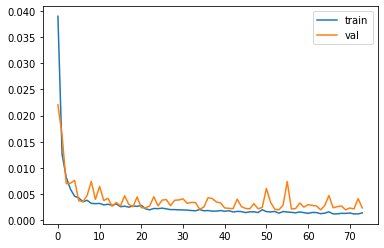

---Training time: 346.21559739 seconds ---


In [ ]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')  
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# # Save the model
# print(model.summary())
# plot_model(model, show_shapes=True)
# model.save('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/Reference_p5270/Reference/DD_Transfer_model_70_10_20.h5')

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing 
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results 
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.98383, Train (V) - 0.95332
R2 scores: Validation (SS) - 0.96515, Validation (V) - 0.93196
R2 scores: Testing (SS) - 0.91316, Testing (V) - 0.85927
RMSE scores: Train (SS) - 0.02267, Train (V) - 0.02174
RMSE scores: Validation (SS) - 0.03792, Validation (V) - 0.03157
RMSE scores: Testing (SS) - 0.05866, Testing (V) - 0.04411


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

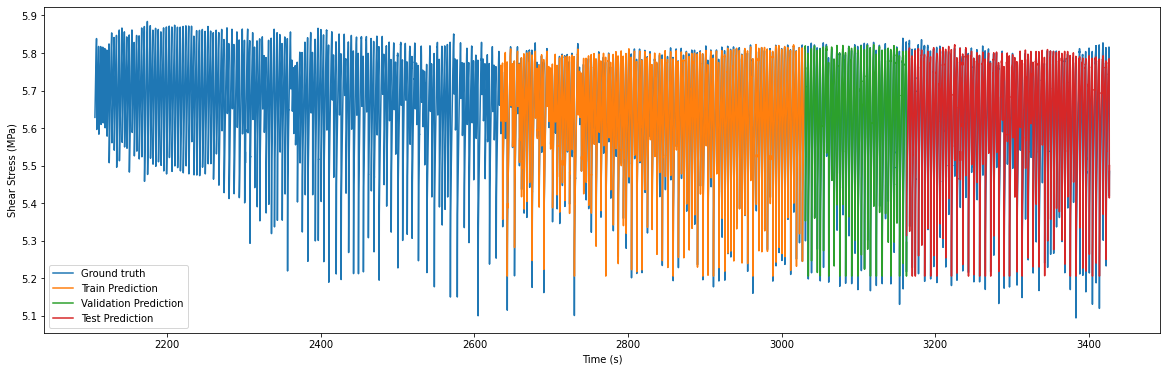

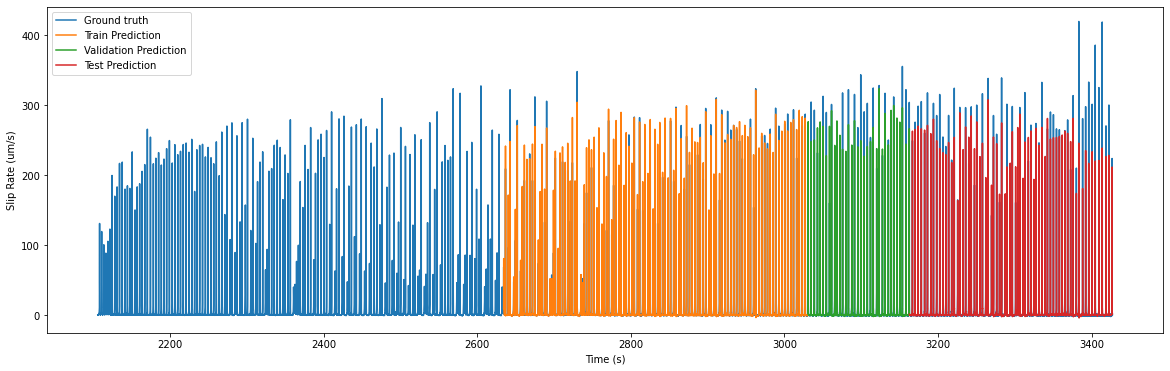

In [ ]:
# Overall plot: SS & V 
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[52839:92469] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

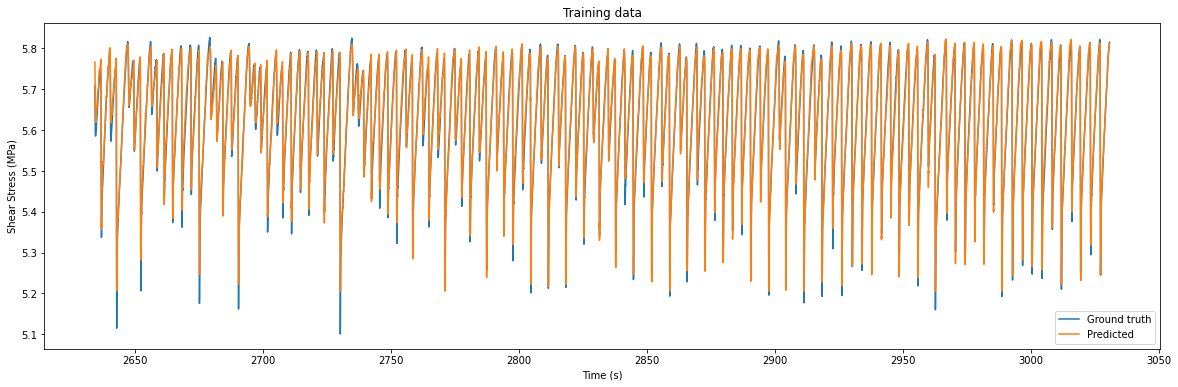

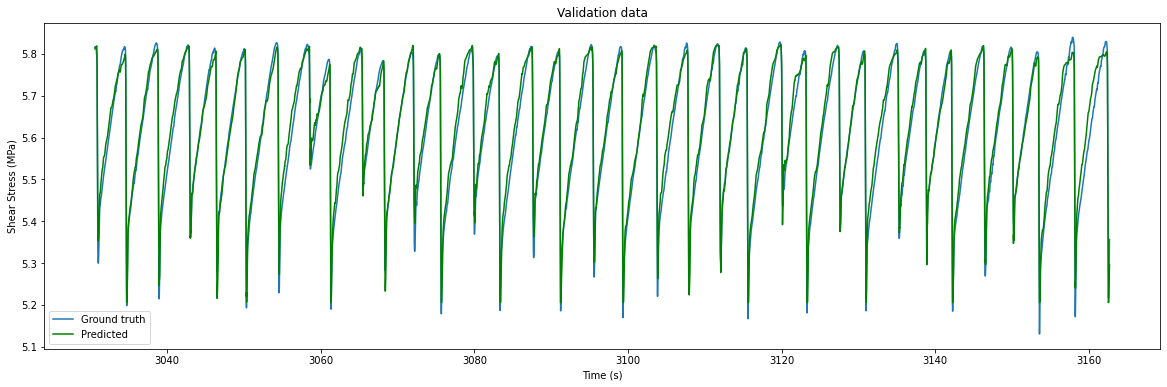

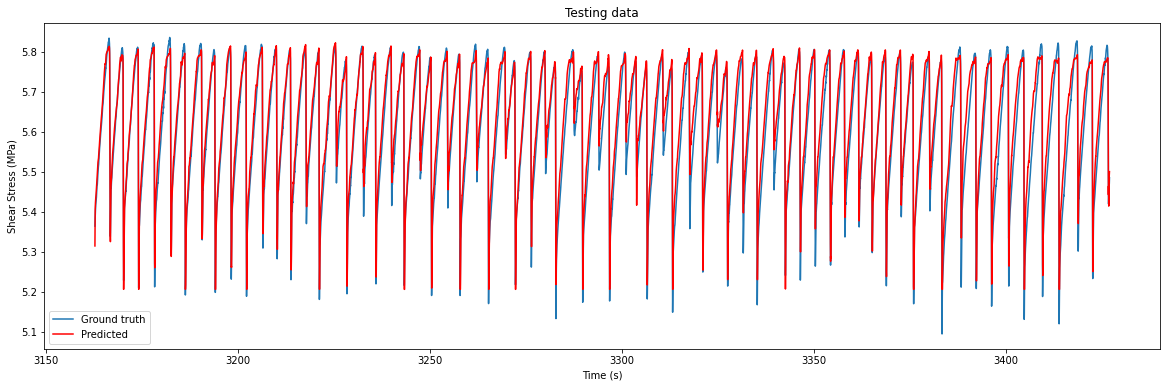

In [ ]:
# Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

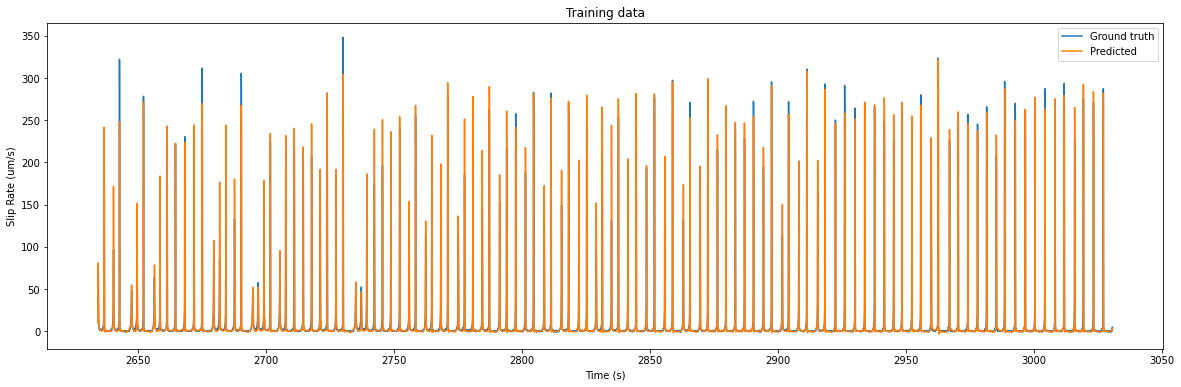

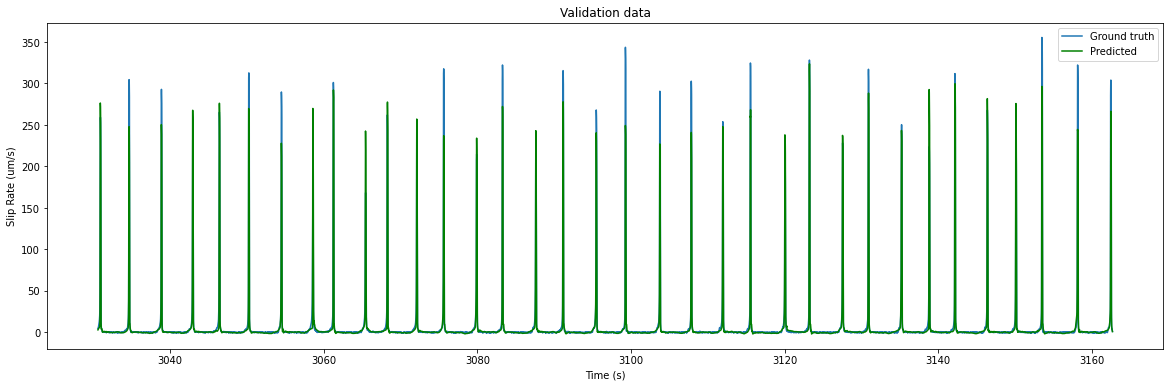

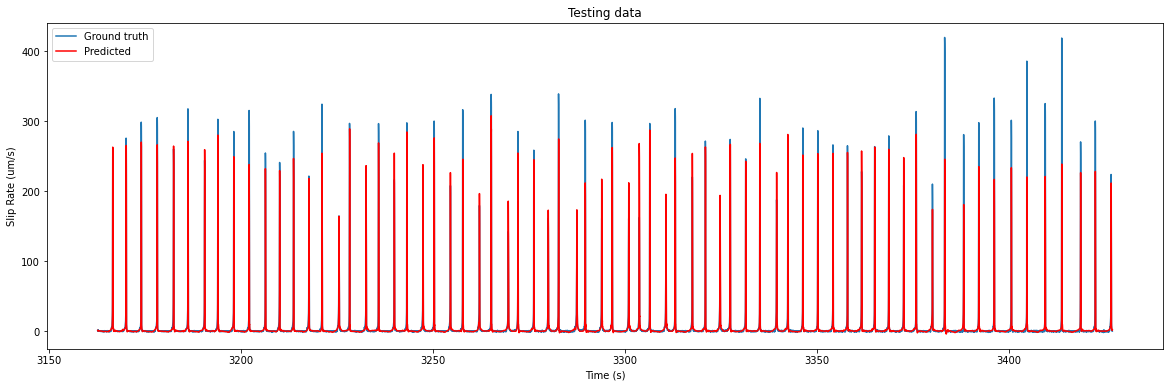

In [ ]:
# Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')

In [ ]:
# # Extract Data

# # Time 
# savetxt('Whole_time.csv', ttime, delimiter=',')
# savetxt('traintime.csv', traintime, delimiter=',')
# savetxt('valtime.csv', valtime, delimiter=',')
# savetxt('testtime.csv', testtime, delimiter=',')

# # SS
# savetxt('Y_train_SS.csv', Y_train_SS, delimiter=',')
# savetxt('Y_val_SS.csv', Y_val_SS, delimiter=',')
# savetxt('y_test_SS.csv', y_test_SS, delimiter=',')
# savetxt('y_predtrain_SS.csv', y_predtrain_SS, delimiter=',')
# savetxt('y_predval_SS.csv', y_predval_SS, delimiter=',')
# savetxt('y_predtest_SS.csv', y_predtest_SS, delimiter=',')

# # V
# savetxt('Y_train_V.csv', Y_train_V, delimiter=',')
# savetxt('Y_val_V.csv', Y_val_V, delimiter=',')
# savetxt('y_test_V.csv', y_test_V, delimiter=',')
# savetxt('y_predtrain_V.csv', y_predtrain_V, delimiter=',')
# savetxt('y_predval_V.csv', y_predval_V, delimiter=',')
# savetxt('y_predtest_V.csv', y_predtest_V, delimiter=',')

# # Download
# files.download('Whole_time.csv')
# files.download('traintime.csv')
# files.download('valtime.csv')
# files.download('testtime.csv')

# files.download('Y_train_SS.csv')
# files.download('Y_val_SS.csv')
# files.download('y_test_SS.csv')
# files.download('y_predtrain_SS.csv')
# files.download('y_predval_SS.csv')
# files.download('y_predtest_SS.csv')

# files.download('Y_train_V.csv')
# files.download('Y_val_V.csv')
# files.download('y_test_V.csv')
# files.download('y_predtrain_V.csv')
# files.download('y_predval_V.csv')
# files.download('y_predtest_V.csv')